In [ ]:
import os
import json
import pandas as pd
from scipy.stats import f_oneway
import seaborn as sns
import matplotlib.pyplot as plt

In [103]:
ruta_carpeta = "/content/resultados_emociones"

# Lista para almacenar los datos de todos los archivos
rows = []

# Recorrer todos los archivos en la carpeta especificada
for root, dirs, files in os.walk(ruta_carpeta):
    for file in files:
        if file.endswith(".txt"):
            file_path = os.path.join(root, file)
            parts = file.split('_')

            # Verificar que el nombre del archivo tiene al menos dos partes separadas por "_"
            if len(parts) >= 2:
                persona = parts[0]
                # Asumir que la extensión está presente y quitarla para obtener solo el nombre de la interfaz
                interfaz = parts[1].split('.')[0]

                with open(file_path, 'r') as f:
                    data = json.loads(f.read())
                    for emocion_obj in data:
                        for emocion, valor in emocion_obj.items():
                            rows.append({
                                "Persona": persona,
                                "Pagina": interfaz,
                                "Emocion": emocion,
                                "Valor": valor
                            })
            else:
                print(f"El archivo {file} no sigue el patrón esperado.")

# Convertir la lista de datos en un DataFrame de pandas
df = pd.DataFrame(rows)



mapeo_paginas = {
    'UI1': 'FreePT',
    'UI2': 'Rehab',
    'UI3': 'PAR Education'
}

# Reemplazar los valores en la columna 'Pagina' usando el mapeo definido
df['Pagina'] = df['Pagina'].replace(mapeo_paginas)

# Mostrar las primeras filas del DataFrame para verificar
df

,Persona,Pagina,Emocion,Valor
0,GMendoza,Rehab,neutral,9.996643e-01
1,GMendoza,Rehab,happy,2.444360e-05
2,GMendoza,Rehab,sad,3.780708e-05
3,GMendoza,Rehab,angry,2.545574e-04
4,GMendoza,Rehab,fearful,1.995086e-07
...,...,...,...,...
212354,AQuilca,FreePT,sad,7.635244e-02
212355,AQuilca,FreePT,angry,4.447767e-03
212356,AQuilca,FreePT,fearful,1.086970e-02
212357,AQuilca,FreePT,disgusted,3.827749e-04


In [104]:
# Supongamos que df es tu DataFrame
# Agrupa los datos por Participante, Página, Interfaz y Emoción, y calcula el promedio de los valores
promedio_emociones = df.groupby(['Persona','Pagina', 'Emocion'])['Valor'].mean().reset_index()

print(promedio_emociones)

         Persona  Pagina    Emocion     Valor
0    ACasagualpa  FreePT      angry  0.006036
1    ACasagualpa  FreePT  disgusted  0.002527
2    ACasagualpa  FreePT    fearful  0.009491
3    ACasagualpa  FreePT      happy  0.009119
4    ACasagualpa  FreePT    neutral  0.936136
..           ...     ...        ...       ...
226      RPIEDRA   Rehab    fearful  0.000959
227      RPIEDRA   Rehab      happy  0.126308
228      RPIEDRA   Rehab    neutral  0.804527
229      RPIEDRA   Rehab        sad  0.012274
230      RPIEDRA   Rehab  surprised  0.055188

[231 rows x 4 columns]


In [ ]:
# promedio_emociones.to_excel('promedio_emociones.xlsx', index=True)

In [105]:
def calcular_cohens_d(datos1, datos2):
    mean1, mean2 = np.mean(datos1), np.mean(datos2)
    n1, n2 = len(datos1), len(datos2)
    std1, std2 = np.std(datos1, ddof=1), np.std(datos2, ddof=1)

    pooled_std = np.sqrt(((n1 - 1) * std1 ** 2 + (n2 - 1) * std2 ** 2) / (n1 + n2 - 2))
    cohens_d = (mean1 - mean2) / pooled_std
    return cohens_d

In [106]:
import numpy as np
resultados_anova = []
# Agrupa los datos por Emoción
for emocion, df_group in promedio_emociones.groupby('Emocion'):
    paginas_data = []

    # Extrae los valores de las tres páginas para la emoción actual
    for _, row in df_group.iterrows():
        paginas_data.append(df[(df['Pagina'] == row['Pagina']) & (df['Emocion'] == emocion)]['Valor'])

    # Calcula el p-value utilizando ANOVA para las tres páginas
    p_value = f_oneway(*paginas_data).pvalue

    ## Calcula Cohen's d para las comparaciones de pares de páginas
    cohens_d_values = []
    for i in range(len(paginas_data)):
        for j in range(i+1, len(paginas_data)):
            cohens_d = calcular_cohens_d(paginas_data[i], paginas_data[j])
            cohens_d_values.append(cohens_d)

    # Calcula el valor medio de Cohen's d para todas las combinaciones de páginas
    mean_cohens_d = np.mean(cohens_d_values)

    resultados_anova.append((emocion, p_value, mean_cohens_d))

In [107]:
resultados_anova_df = pd.DataFrame(resultados_anova, columns=['Emocion', 'p-value', "Cohen's d"])

# Imprime los resultados del ANOVA
print("Resultados ANOVA por Emoción:")
print(resultados_anova_df)

Resultados ANOVA por Emoción:
     Emocion        p-value  Cohen's d
0      angry  5.340775e-212  -0.000019
1  disgusted   2.599522e-12  -0.001879
2    fearful   6.426987e-09  -0.001142
3      happy  6.657639e-228  -0.006292
4    neutral   0.000000e+00   0.003551
5        sad   0.000000e+00   0.000542
6  surprised   3.317304e-04  -0.000633


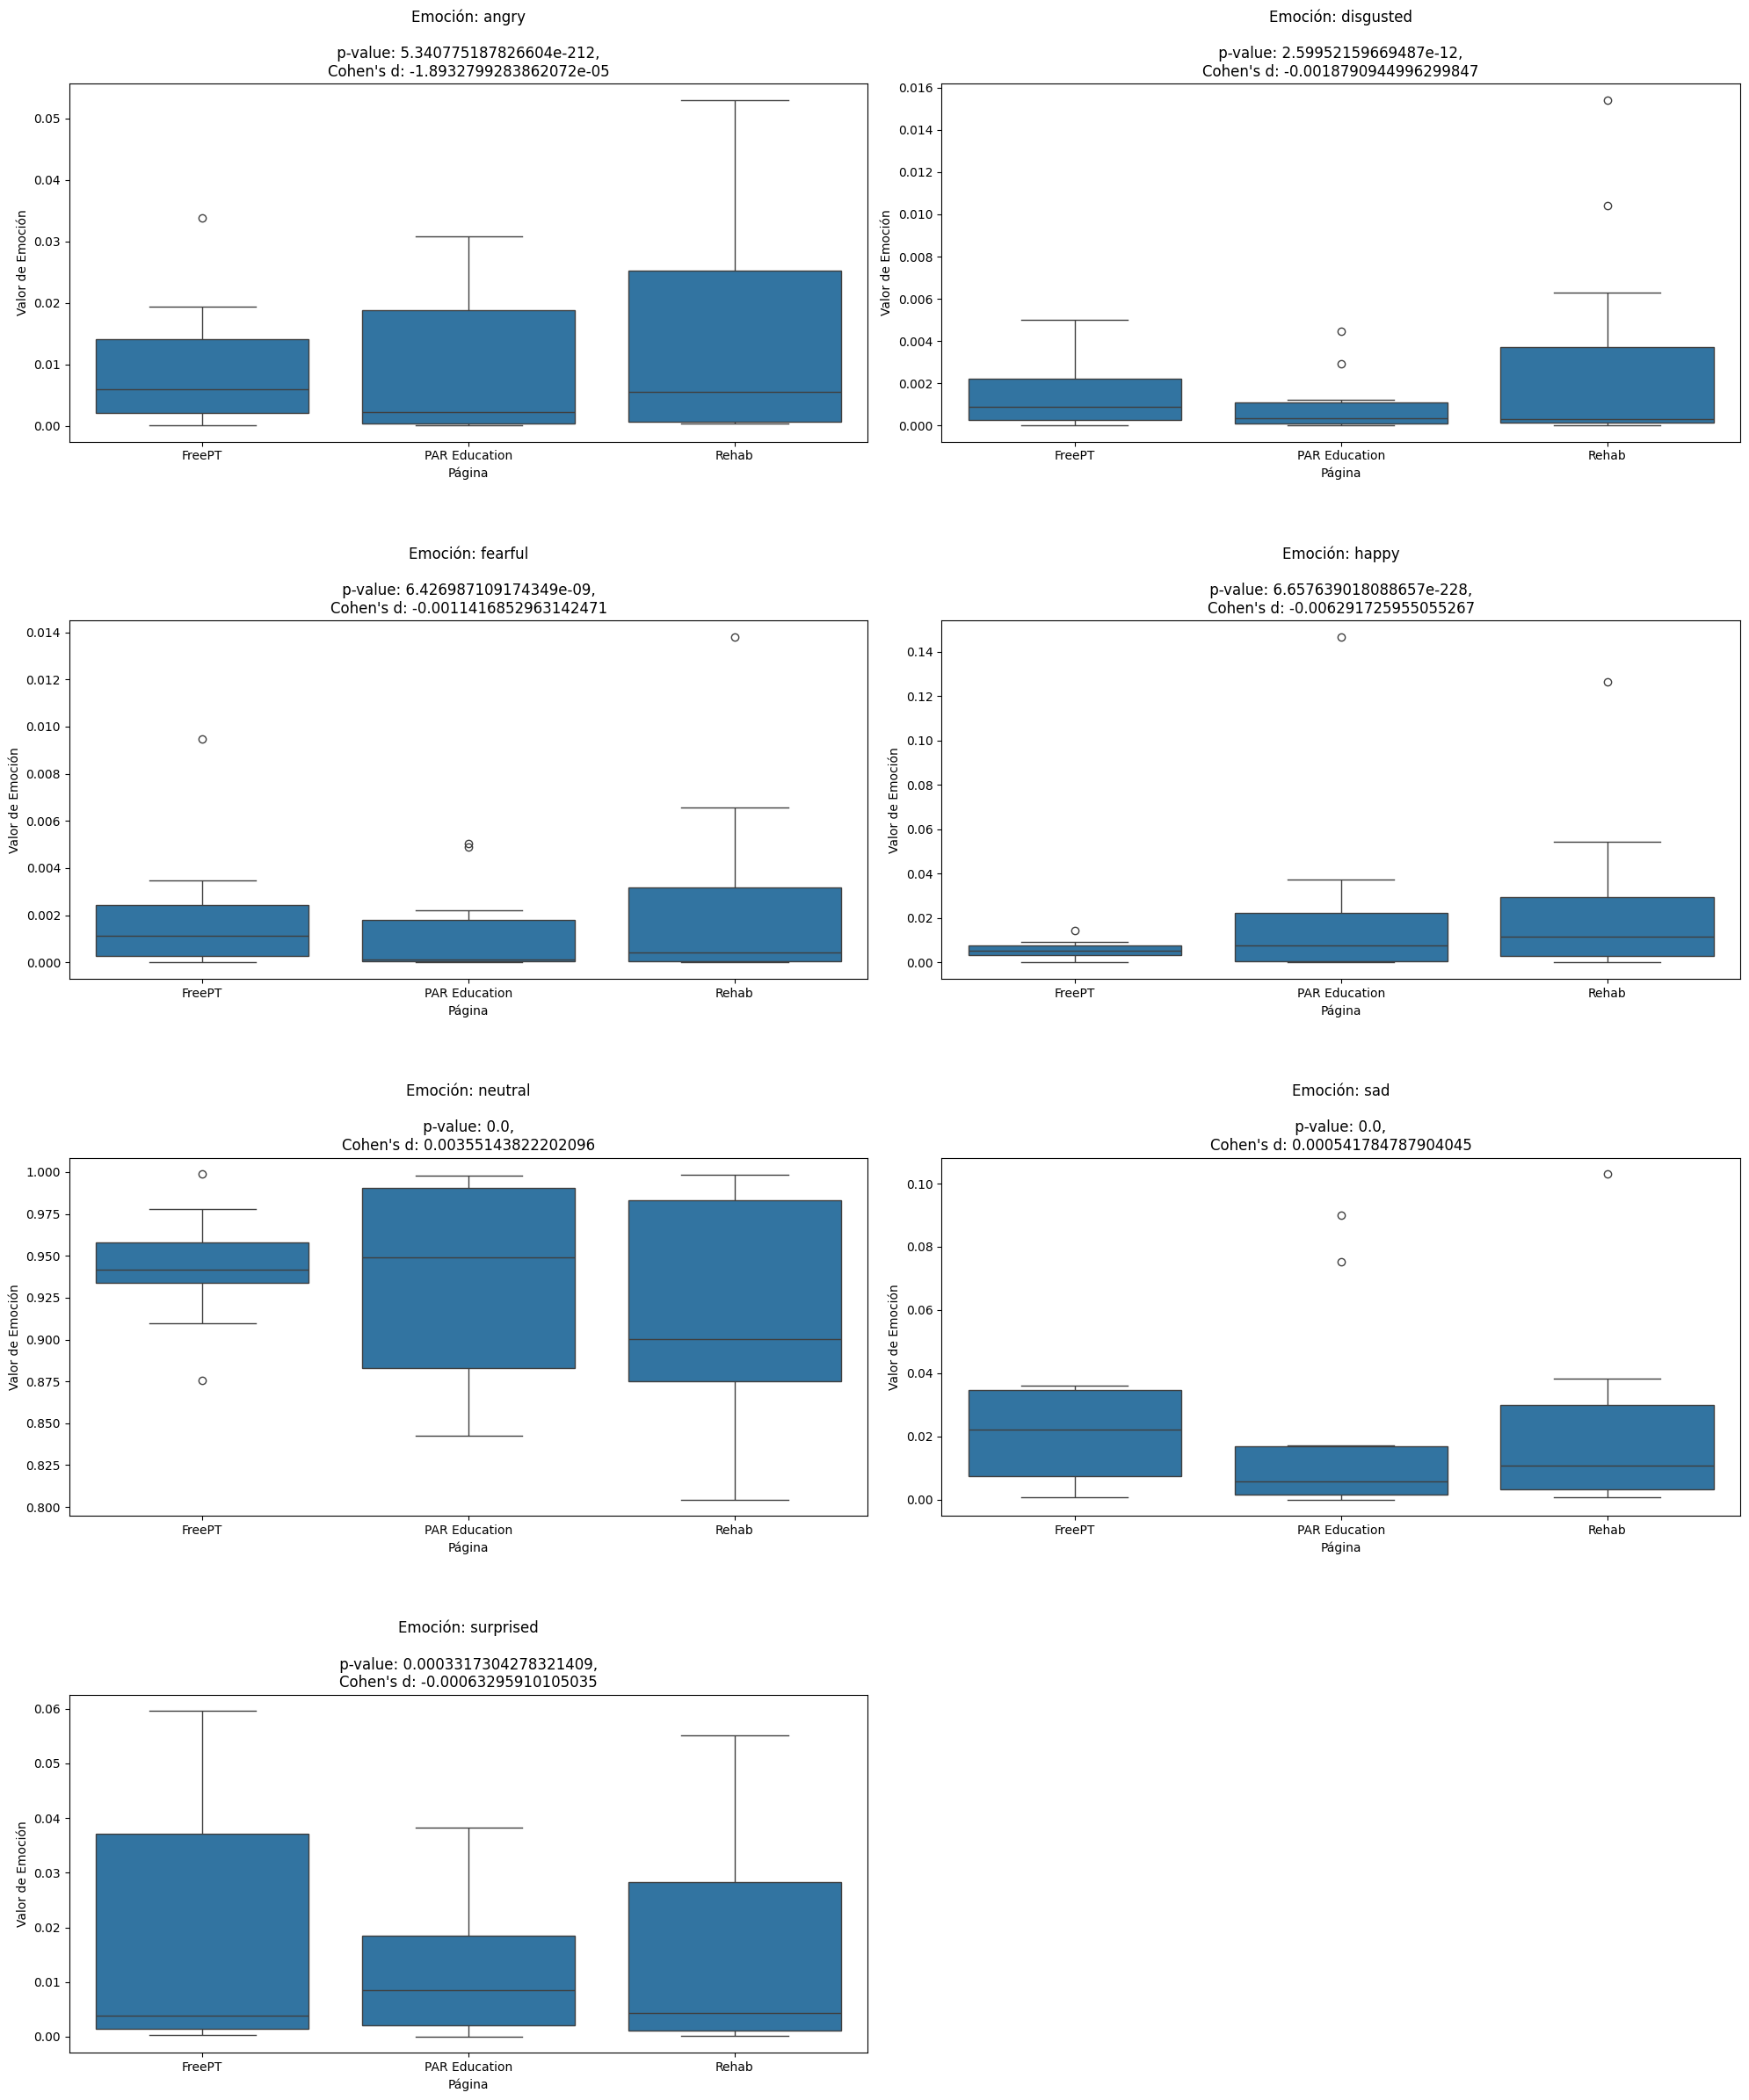

In [108]:
# Calcular el número de subplots necesarios
num_subplots = len(resultados_anova_df)

# Calcular el número de filas y columnas necesarias
num_cols = 2
num_rows = -(-num_subplots // num_cols)  # Round up division

# Crear la figura para los diagramas de caja
plt.figure(figsize=(20, 6*num_rows))

# Crear los diagramas de caja para cada emoción
for index, (emocion, p_value, cohens_d) in resultados_anova_df.iterrows():
    plt.subplot(num_rows, num_cols, index + 1)
    data_emocion = promedio_emociones[promedio_emociones['Emocion'] == emocion]
    sns.boxplot(data=data_emocion, x='Pagina', y='Valor')
    plt.title(f'Emoción: {emocion}\n\n p-value: {p_value}, \nCohen\'s d: {cohens_d}')

    plt.xlabel('Página')
    plt.ylabel('Valor de Emoción')

# Ajustar espaciado entre subplots
plt.tight_layout()
plt.subplots_adjust(hspace=0.5)
plt.show()